<a href="https://colab.research.google.com/github/smartdesignlab/SDL_teaching/blob/main/cGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# cGAN (Conditional GAN)

- cGAN : https://arxiv.org/pdf/1411.1784 (discrete conditions)
- CcGAN : https://openreview.net/pdf?id=PrzjugOsDeE (continuous, scalar conditions)


## 1. Load dataset

In [ ]:
!gdown --folder https://drive.google.com/drive/folders/12_pMH77NyqSnp8NY0EFzZn1dODgrx_p8?usp=drive_link
!unzip dataset/data_2000.zip -d ./data2000

Retrieving folder contents
Processing file 1T6zw4ggFfFlPQChqWia-VLKct1DTSLK6 data_500.zip
Processing file 1kHHoZPyk0_lCJYwqqaxd0hmBAdAxqEQY data_1000.zip
Processing file 12M-FQcVzzumCnhmFrzPkzeBoBZQtBSbj data_2000.zip
Processing file 1pNYu7bAEp8Lw08-VXMmHAgmEnJNhuhAF data_3000.zip
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1T6zw4ggFfFlPQChqWia-VLKct1DTSLK6
To: /content/dataset/data_500.zip
100% 567k/567k [00:00<00:00, 99.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1kHHoZPyk0_lCJYwqqaxd0hmBAdAxqEQY
To: /content/dataset/data_1000.zip
100% 1.20M/1.20M [00:00<00:00, 43.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=12M-FQcVzzumCnhmFrzPkzeBoBZQtBSbj
To: /content/dataset/data_2000.zip
100% 2.27M/2.27M [00:00<00:00, 189MB/s]
Downloading...
From: https://drive.google.com/uc?id=1pNYu7bAEp8Lw08-VXMmHAgmEnJNhuhAF
To: /content/dataset/data_3000.zip
100% 3.31M

## 2. Import python libraries and define util functions

In [ ]:
import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt
import os
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader,TensorDataset
from torch.utils.data.dataset import random_split
from torchvision.utils import save_image
from torchsummary import summary

import scipy.io
from sklearn.model_selection import train_test_split

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# function to set seed
def set_seed(seed=42):
    # fix random seed
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    # CuDNN setup
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# function to read and display images
def img_read_plot(src,file):
    img = cv.imread(src+file,cv.COLOR_BGR2GRAY)  # convert the image to grayscale
    plt.imshow(img, cmap='gray')
    plt.xticks([])  # x axis
    plt.yticks([])  # y axis
    plt.show()  # display the image
    return img

# function to read images
def img_read(src,file):
    img = cv.imread(src+file,cv.COLOR_BGR2GRAY)  # convert the image to grayscale
    return img

# function to plot a line graph for loss history after model training
def plot_loss(g_loss, d_loss, title=None):

    plt.plot(g_loss)
    plt.plot(d_loss)
    if title is not None:
        plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(['Generator Loss', 'Discriminator Loss'], loc=0)
    # plt.show()

In [ ]:
set_seed(0)

## 3. Check dataset

In [ ]:
path = './data2000/23.119.jpg'
from PIL import Image
img = Image.open(path)
img.show()
img_array = np.array(img)
print(img_array.shape)

(56, 56)


## 4. Convert images into trainable data

In [ ]:
# image size = 56 x 56, 2000 images

# specify the below path to the unzipped data (ensure it ends with '/')
# you can change the file path if needed
src = './data2000/'

# loop through the files, read each image, and normalize it (-1 to 1)
def get_data():
    files = os.listdir(src)  # get the list of files in the source directory
    X,Y = [],[]  # initialize empty lists for storing images and labels

    for file in files:
        X.append((img_read(src,file)-127.5)/127.5)  # normalize the data between -1 and 1
        Y.append(float(file[:-4]))  # extract label from filename

    X = np.array(X)  # convert the list of images to a numpy array
    Y = np.array(Y)  # convert the list of labels to a numpy array

    # split the data into 80% training set and 20% test set (test set can be considered as validation)
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1, shuffle=True)

    # expand dimension to (batch_size, 1, height, width) in PyTorch
    X_train = np.expand_dims(X_train, axis=1)  # axis=1 for channel in PyTorch
    X_test = np.expand_dims(X_test, axis=1)  # same for test set

    # normalize Y to a specific range, e.g., [-1, 1], improving training performance
    y_min, y_max = y_train.min(), y_train.max()
    y_train_norm = 2 * (y_train - y_min) / (y_max - y_min) - 1  # Normalize to [-1, 1]
    y_test_norm = 2 * (y_test - y_min) / (y_max - y_min) - 1    # Use the same scale as training

    return X_train, X_test, y_train_norm, y_test_norm

X_train, X_test, y_train, y_test = get_data()  # load data set

print("X_train.shape =", X_train.shape)  # Expected: (N_train, 1, 56, 56)
print("y_train.shape =", y_train.shape)  # Expected: (N_train,)
print("X_test.shape =", X_test.shape)    # Expected: (N_test, 1, 56, 56)
print("y_test.shape =", y_test.shape)    # Expected: (N_test,)

X_train.shape = (1600, 1, 56, 56)
y_train.shape = (1600,)
X_test.shape = (400, 1, 56, 56)
y_test.shape = (400,)


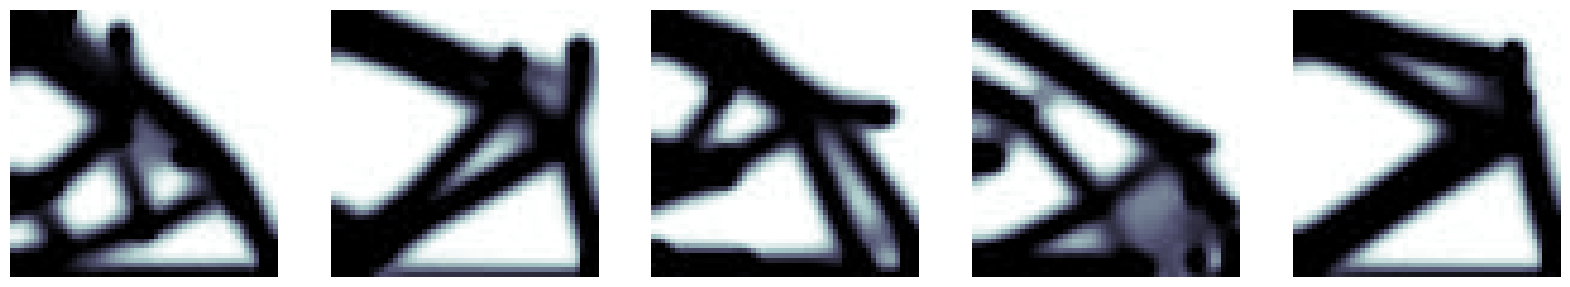

In [ ]:
# display images
fig = plt.figure(figsize=(20,10))
nplot = 5

for i in range(1,nplot+1):
    ax = fig.add_subplot(1,nplot,i)
    ax.imshow(X_train[i, 0, :, :],cmap = plt.cm.bone)
    ax.axis('off')
plt.show()

## 5. Set to model architecture

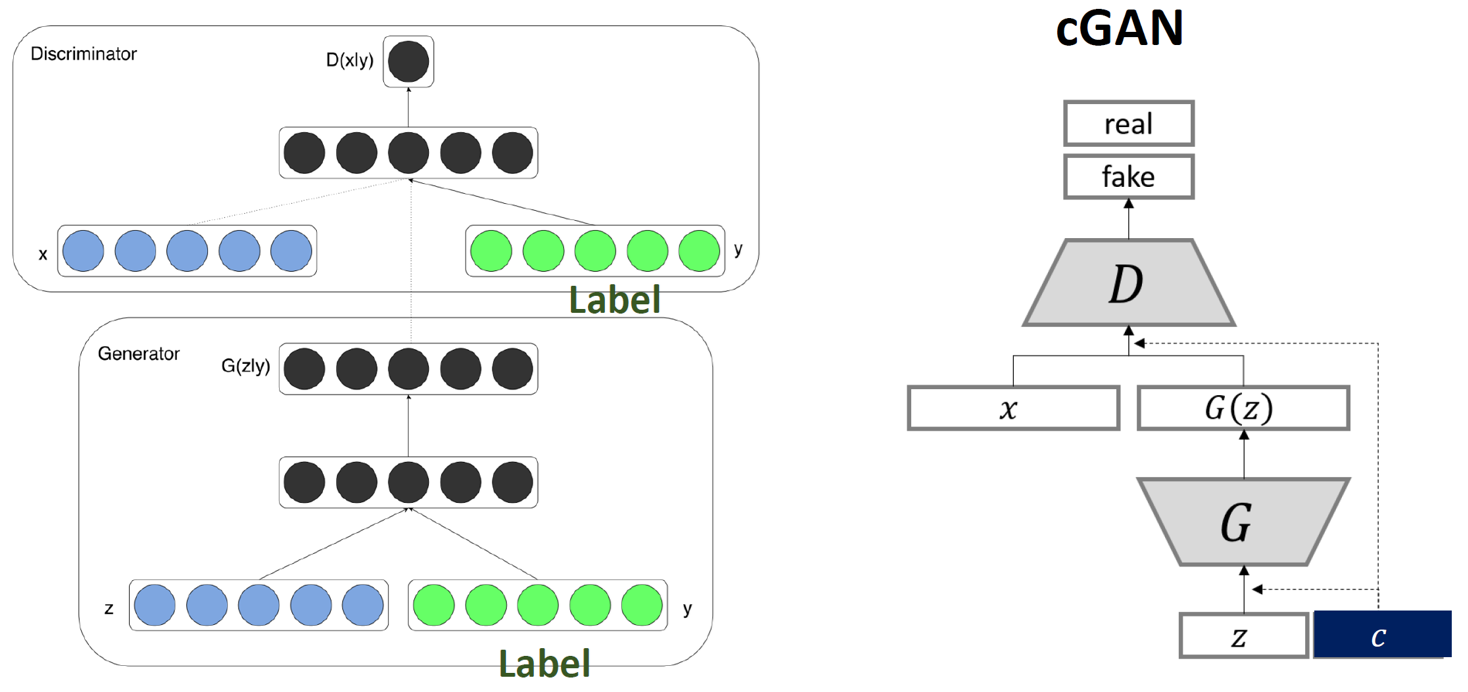

https://arxiv.org/pdf/1411.1784

https://github.com/hwalsuklee/tensorflow-generative-model-collections

In [ ]:
# ---------------------
#  Generator Network (input : noise >> output : image)
# ---------------------

class Generator(nn.Module):  # generate real-looking images
    def __init__(self, noise_size, label_size, hidden_size1=256, hidden_size2=512, hidden_size3=1024, img_size=56*56):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(noise_size + label_size, hidden_size1),
            nn.ReLU(True),
            nn.Linear(hidden_size1, hidden_size2),
            nn.ReLU(True),
            nn.Linear(hidden_size2, hidden_size3),
            nn.ReLU(True),
            nn.Linear(hidden_size3, img_size),
            nn.Tanh()  # output values in [-1, 1]
        )

    def forward(self, noise, labels):

        gen_input = torch.cat((noise, labels), dim=1)  # concatenate noise and labels
        img = self.model(gen_input)

        return img

# ---------------------
#  Discriminator Network (input : image >> output : [1 / Real] or [0 / Fake])
# ---------------------

class Discriminator(nn.Module):  # distinguish between real and fake images
    def __init__(self, label_size, hidden_size1=256, hidden_size2=512, hidden_size3=1024, img_size=56*56):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(img_size + label_size, hidden_size3),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(hidden_size3, hidden_size2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(hidden_size2, hidden_size1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(hidden_size1, 1),
            nn.Sigmoid()  # output probability between [0, 1]
        )

    def forward(self, img, labels):

        dis_input = torch.cat((img, labels), dim=1)  # concatenate image and labels
        validity = self.model(dis_input)

        return validity

## 6. Set model hyperparameters

In [ ]:
# model architecture parameters
hidden_size1 = 256
hidden_size2 = 512
hidden_size3 = 1024
noise_size = 100
label_size = 1  # since Y is a single continuous value

# training parameters
learning_rate = 0.0002
batch_size = 32
num_epoch = 500

# fixed values
img_size = 56 * 56              # image size
num_channel = 1                 # grayscale images
img_shape = (num_channel,56,56) # grayscale images

## 7. Train model

In [ ]:
# define networks and set to device (GPU)
generator = Generator(noise_size=noise_size, label_size=label_size).to(device)
discriminator = Discriminator(label_size=label_size).to(device)

# convert data to PyTorch tensors
train_images = torch.tensor(X_train, dtype=torch.float32).to(device)
train_labels = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).to(device)  # Shape: (N, 1)

# create DataLoader for training and validation data
train_dataset = TensorDataset(train_images, train_labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# set to loss function & optimizer
criterion = nn.BCELoss() # binary cross entropy loss for binary classification
g_optimizer = torch.optim.Adam(generator.parameters(), lr=learning_rate)
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=learning_rate)

# lists to track training and validation history
g_loss_history = []  # generator loss history
d_loss_history = []  # discriminator loss history

In [ ]:
# fixed noise and labels for visualization
fixed_labels = torch.linspace(-1, 1, steps=10).unsqueeze(1).to(device)  # example fixed labels in [-1, 1]
fixed_noise = torch.randn(10, noise_size).to(device)

# create a directory to save generated images
os.makedirs("./cGAN_samples/", exist_ok=True)

Epoch [1/500]  D Loss: 0.4629  G Loss: 1.2050


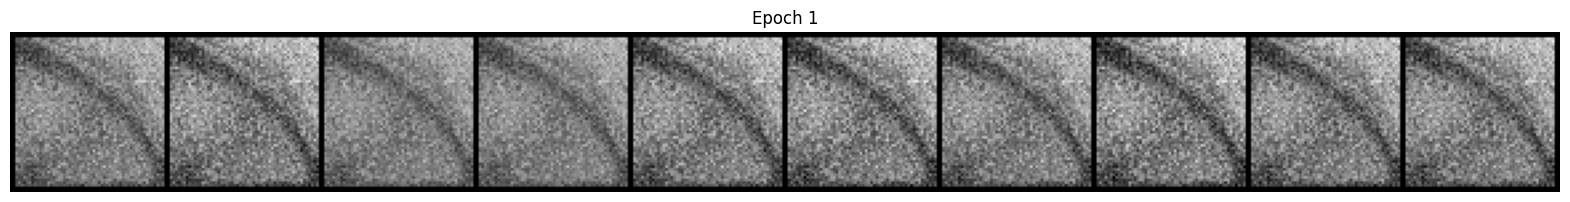

Epoch [2/500]  D Loss: 0.2356  G Loss: 1.7024
Epoch [3/500]  D Loss: 0.1403  G Loss: 3.3567
Epoch [4/500]  D Loss: 0.4388  G Loss: 1.9594
Epoch [5/500]  D Loss: 0.2617  G Loss: 2.5381
Epoch [6/500]  D Loss: 0.3882  G Loss: 3.0357
Epoch [7/500]  D Loss: 0.5431  G Loss: 1.4712
Epoch [8/500]  D Loss: 0.3420  G Loss: 4.2949
Epoch [9/500]  D Loss: 0.2761  G Loss: 5.2231
Epoch [10/500]  D Loss: 0.1886  G Loss: 8.4330
Epoch [11/500]  D Loss: 0.0862  G Loss: 9.1123
Epoch [12/500]  D Loss: 0.1271  G Loss: 6.6319
Epoch [13/500]  D Loss: 0.0866  G Loss: 5.7649
Epoch [14/500]  D Loss: 0.1819  G Loss: 4.3828
Epoch [15/500]  D Loss: 0.0942  G Loss: 5.0141
Epoch [16/500]  D Loss: 0.0927  G Loss: 4.4305
Epoch [17/500]  D Loss: 0.1590  G Loss: 7.1271
Epoch [18/500]  D Loss: 0.4688  G Loss: 6.6818
Epoch [19/500]  D Loss: 0.1720  G Loss: 5.7407
Epoch [20/500]  D Loss: 0.1508  G Loss: 6.8125
Epoch [21/500]  D Loss: 0.1135  G Loss: 6.5191
Epoch [22/500]  D Loss: 0.0966  G Loss: 6.1808
Epoch [23/500]  D Los

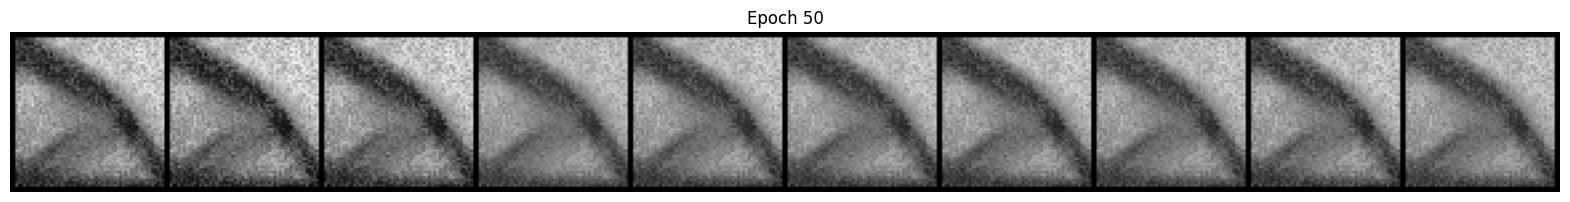

Epoch [51/500]  D Loss: 0.3241  G Loss: 2.2082
Epoch [52/500]  D Loss: 0.0968  G Loss: 3.0723
Epoch [53/500]  D Loss: 0.0520  G Loss: 3.9471
Epoch [54/500]  D Loss: 0.1207  G Loss: 4.0653
Epoch [55/500]  D Loss: 0.1155  G Loss: 4.6774
Epoch [56/500]  D Loss: 0.1481  G Loss: 4.5963
Epoch [57/500]  D Loss: 0.1039  G Loss: 5.7331
Epoch [58/500]  D Loss: 0.1783  G Loss: 3.0201
Epoch [59/500]  D Loss: 0.0696  G Loss: 5.0105
Epoch [60/500]  D Loss: 0.1564  G Loss: 4.4617
Epoch [61/500]  D Loss: 0.2708  G Loss: 2.5827
Epoch [62/500]  D Loss: 0.1201  G Loss: 4.2081
Epoch [63/500]  D Loss: 0.1290  G Loss: 4.3522
Epoch [64/500]  D Loss: 0.0876  G Loss: 4.3694
Epoch [65/500]  D Loss: 0.0767  G Loss: 4.8852
Epoch [66/500]  D Loss: 0.4109  G Loss: 3.6369
Epoch [67/500]  D Loss: 0.0767  G Loss: 3.7203
Epoch [68/500]  D Loss: 0.0925  G Loss: 4.3391
Epoch [69/500]  D Loss: 0.1333  G Loss: 3.3286
Epoch [70/500]  D Loss: 0.0829  G Loss: 7.4067
Epoch [71/500]  D Loss: 0.2179  G Loss: 4.7256
Epoch [72/500

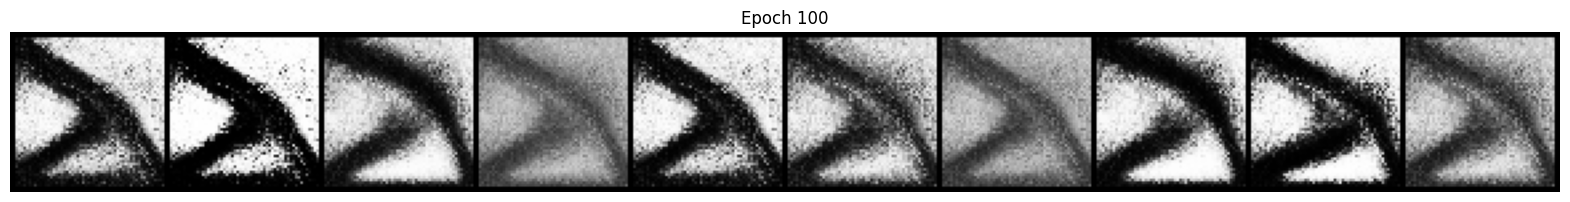

Epoch [101/500]  D Loss: 0.2132  G Loss: 4.2026
Epoch [102/500]  D Loss: 0.1180  G Loss: 4.5620
Epoch [103/500]  D Loss: 0.1148  G Loss: 4.0560
Epoch [104/500]  D Loss: 0.1422  G Loss: 3.5093
Epoch [105/500]  D Loss: 0.1716  G Loss: 3.6425
Epoch [106/500]  D Loss: 0.1494  G Loss: 3.8264
Epoch [107/500]  D Loss: 0.1378  G Loss: 4.0265
Epoch [108/500]  D Loss: 0.1572  G Loss: 4.2908
Epoch [109/500]  D Loss: 0.1376  G Loss: 4.4590
Epoch [110/500]  D Loss: 0.1178  G Loss: 4.1802
Epoch [111/500]  D Loss: 0.1589  G Loss: 4.1540
Epoch [112/500]  D Loss: 0.1290  G Loss: 4.4704
Epoch [113/500]  D Loss: 0.1527  G Loss: 4.0102
Epoch [114/500]  D Loss: 0.1772  G Loss: 3.9740
Epoch [115/500]  D Loss: 0.1604  G Loss: 4.4776
Epoch [116/500]  D Loss: 0.1684  G Loss: 3.8862
Epoch [117/500]  D Loss: 0.1585  G Loss: 3.9500
Epoch [118/500]  D Loss: 0.1827  G Loss: 3.7422
Epoch [119/500]  D Loss: 0.1844  G Loss: 4.1166
Epoch [120/500]  D Loss: 0.1524  G Loss: 4.3191
Epoch [121/500]  D Loss: 0.1346  G Loss:

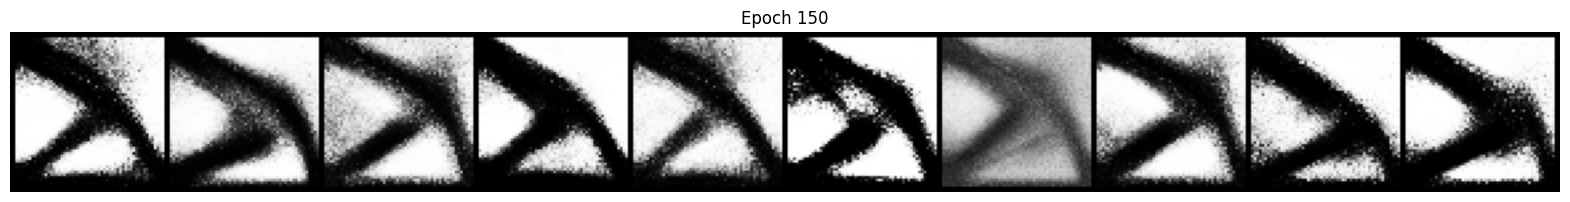

Epoch [151/500]  D Loss: 0.2430  G Loss: 3.5992
Epoch [152/500]  D Loss: 0.1855  G Loss: 3.3523
Epoch [153/500]  D Loss: 0.1988  G Loss: 3.7761
Epoch [154/500]  D Loss: 0.1890  G Loss: 3.6561
Epoch [155/500]  D Loss: 0.1936  G Loss: 3.7697
Epoch [156/500]  D Loss: 0.1970  G Loss: 3.5779
Epoch [157/500]  D Loss: 0.1789  G Loss: 3.6760
Epoch [158/500]  D Loss: 0.2034  G Loss: 3.6478
Epoch [159/500]  D Loss: 0.1945  G Loss: 3.5286
Epoch [160/500]  D Loss: 0.1575  G Loss: 3.8883
Epoch [161/500]  D Loss: 0.1944  G Loss: 3.8449
Epoch [162/500]  D Loss: 0.1826  G Loss: 3.7767
Epoch [163/500]  D Loss: 0.1822  G Loss: 3.1721
Epoch [164/500]  D Loss: 0.1706  G Loss: 3.5712
Epoch [165/500]  D Loss: 0.2347  G Loss: 3.3673
Epoch [166/500]  D Loss: 0.2123  G Loss: 3.4406
Epoch [167/500]  D Loss: 0.1854  G Loss: 3.5916
Epoch [168/500]  D Loss: 0.2169  G Loss: 3.5297
Epoch [169/500]  D Loss: 0.2347  G Loss: 3.2621
Epoch [170/500]  D Loss: 0.2077  G Loss: 3.7752
Epoch [171/500]  D Loss: 0.2013  G Loss:

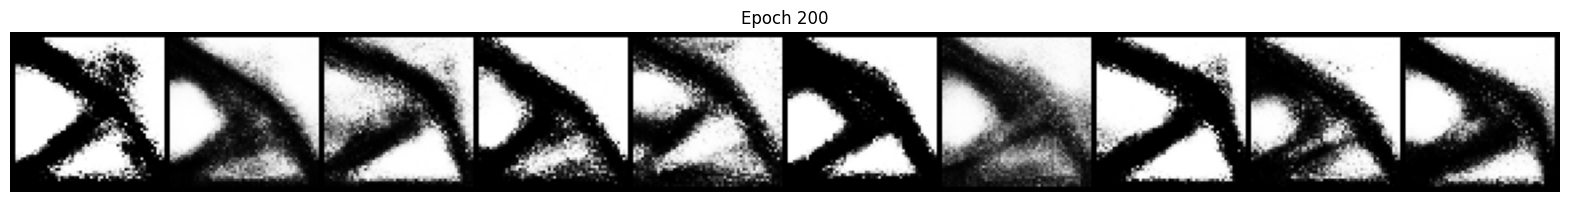

Epoch [201/500]  D Loss: 0.2243  G Loss: 3.1271
Epoch [202/500]  D Loss: 0.2685  G Loss: 3.0451
Epoch [203/500]  D Loss: 0.2571  G Loss: 2.9413
Epoch [204/500]  D Loss: 0.2357  G Loss: 3.2961
Epoch [205/500]  D Loss: 0.3164  G Loss: 2.6454
Epoch [206/500]  D Loss: 0.2327  G Loss: 3.0290
Epoch [207/500]  D Loss: 0.2664  G Loss: 3.1202
Epoch [208/500]  D Loss: 0.2815  G Loss: 2.7243
Epoch [209/500]  D Loss: 0.2776  G Loss: 2.8918
Epoch [210/500]  D Loss: 0.2842  G Loss: 2.7304
Epoch [211/500]  D Loss: 0.2672  G Loss: 2.8369
Epoch [212/500]  D Loss: 0.2821  G Loss: 2.7841
Epoch [213/500]  D Loss: 0.2976  G Loss: 2.6374
Epoch [214/500]  D Loss: 0.2773  G Loss: 2.7733
Epoch [215/500]  D Loss: 0.3279  G Loss: 2.5449
Epoch [216/500]  D Loss: 0.2445  G Loss: 3.0626
Epoch [217/500]  D Loss: 0.3318  G Loss: 2.7323
Epoch [218/500]  D Loss: 0.3041  G Loss: 2.6061
Epoch [219/500]  D Loss: 0.2759  G Loss: 3.0125
Epoch [220/500]  D Loss: 0.3264  G Loss: 2.5931
Epoch [221/500]  D Loss: 0.2940  G Loss:

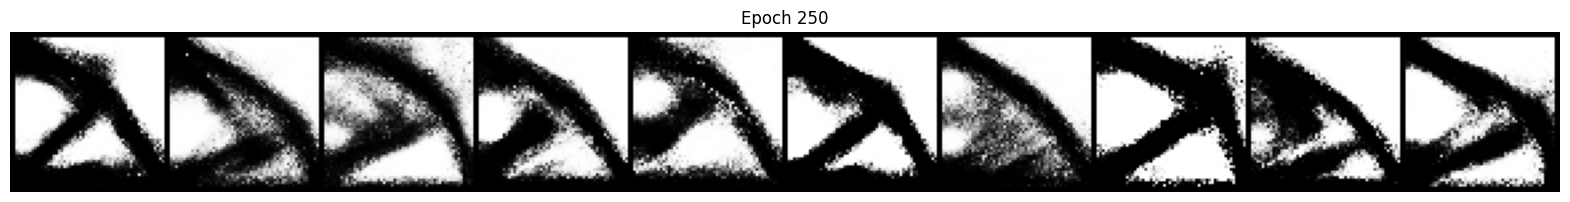

Epoch [251/500]  D Loss: 0.2857  G Loss: 2.8370
Epoch [252/500]  D Loss: 0.2942  G Loss: 2.7894
Epoch [253/500]  D Loss: 0.3106  G Loss: 2.8286
Epoch [254/500]  D Loss: 0.3103  G Loss: 2.7651
Epoch [255/500]  D Loss: 0.2793  G Loss: 2.9138
Epoch [256/500]  D Loss: 0.2832  G Loss: 2.7046
Epoch [257/500]  D Loss: 0.3222  G Loss: 2.7037
Epoch [258/500]  D Loss: 0.3216  G Loss: 2.6458
Epoch [259/500]  D Loss: 0.2636  G Loss: 2.7105
Epoch [260/500]  D Loss: 0.3524  G Loss: 2.7110
Epoch [261/500]  D Loss: 0.3043  G Loss: 2.7968
Epoch [262/500]  D Loss: 0.2660  G Loss: 2.8824
Epoch [263/500]  D Loss: 0.3292  G Loss: 2.6899
Epoch [264/500]  D Loss: 0.2967  G Loss: 2.5073
Epoch [265/500]  D Loss: 0.2638  G Loss: 2.9464
Epoch [266/500]  D Loss: 0.3066  G Loss: 2.9020
Epoch [267/500]  D Loss: 0.3081  G Loss: 2.9338
Epoch [268/500]  D Loss: 0.3140  G Loss: 2.8045
Epoch [269/500]  D Loss: 0.3231  G Loss: 2.7857
Epoch [270/500]  D Loss: 0.3179  G Loss: 2.6509
Epoch [271/500]  D Loss: 0.3189  G Loss:

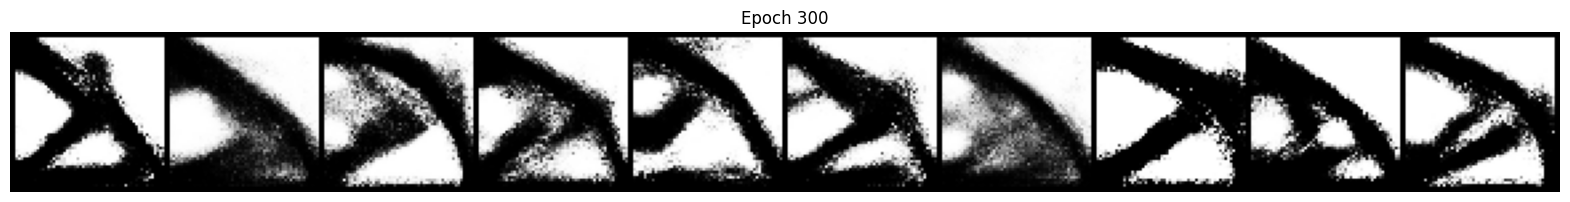

Epoch [301/500]  D Loss: 0.3190  G Loss: 2.5656
Epoch [302/500]  D Loss: 0.3145  G Loss: 2.5257
Epoch [303/500]  D Loss: 0.3100  G Loss: 2.7019
Epoch [304/500]  D Loss: 0.3271  G Loss: 2.5581
Epoch [305/500]  D Loss: 0.3121  G Loss: 2.7402
Epoch [306/500]  D Loss: 0.3489  G Loss: 2.5013
Epoch [307/500]  D Loss: 0.3409  G Loss: 2.5271
Epoch [308/500]  D Loss: 0.3034  G Loss: 2.6226
Epoch [309/500]  D Loss: 0.3425  G Loss: 2.4766
Epoch [310/500]  D Loss: 0.3278  G Loss: 2.6509
Epoch [311/500]  D Loss: 0.3210  G Loss: 2.6235
Epoch [312/500]  D Loss: 0.3320  G Loss: 2.5348
Epoch [313/500]  D Loss: 0.3344  G Loss: 2.4537
Epoch [314/500]  D Loss: 0.3190  G Loss: 2.5537
Epoch [315/500]  D Loss: 0.3355  G Loss: 2.5946
Epoch [316/500]  D Loss: 0.3475  G Loss: 2.4200
Epoch [317/500]  D Loss: 0.3250  G Loss: 2.6616
Epoch [318/500]  D Loss: 0.3301  G Loss: 2.6139
Epoch [319/500]  D Loss: 0.3749  G Loss: 2.4082
Epoch [320/500]  D Loss: 0.3136  G Loss: 2.7102
Epoch [321/500]  D Loss: 0.3489  G Loss:

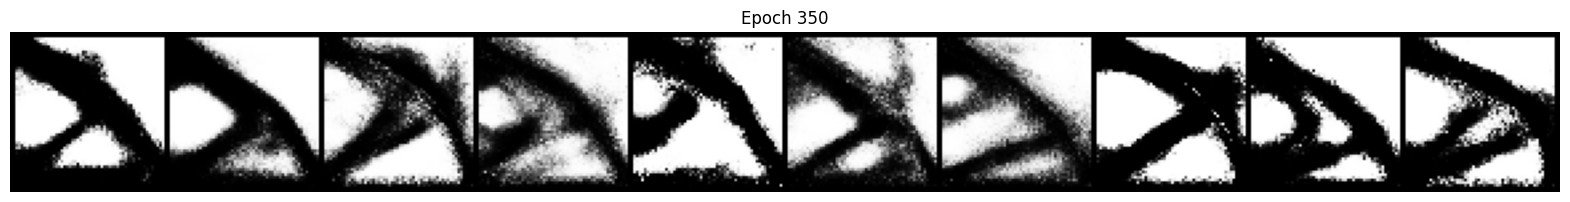

Epoch [351/500]  D Loss: 0.3311  G Loss: 2.5430
Epoch [352/500]  D Loss: 0.3138  G Loss: 2.7188
Epoch [353/500]  D Loss: 0.3574  G Loss: 2.4772
Epoch [354/500]  D Loss: 0.3480  G Loss: 2.4478
Epoch [355/500]  D Loss: 0.2908  G Loss: 2.6782
Epoch [356/500]  D Loss: 0.3438  G Loss: 2.4692
Epoch [357/500]  D Loss: 0.3312  G Loss: 2.4769
Epoch [358/500]  D Loss: 0.3089  G Loss: 2.5943
Epoch [359/500]  D Loss: 0.3237  G Loss: 2.5797
Epoch [360/500]  D Loss: 0.3404  G Loss: 2.3987
Epoch [361/500]  D Loss: 0.3216  G Loss: 2.7887
Epoch [362/500]  D Loss: 0.3380  G Loss: 2.5396
Epoch [363/500]  D Loss: 0.3246  G Loss: 2.5842
Epoch [364/500]  D Loss: 0.3187  G Loss: 2.5695
Epoch [365/500]  D Loss: 0.3353  G Loss: 2.4652
Epoch [366/500]  D Loss: 0.3573  G Loss: 2.5757
Epoch [367/500]  D Loss: 0.3275  G Loss: 2.5479
Epoch [368/500]  D Loss: 0.3110  G Loss: 2.7435
Epoch [369/500]  D Loss: 0.3542  G Loss: 2.4163
Epoch [370/500]  D Loss: 0.3502  G Loss: 2.3140
Epoch [371/500]  D Loss: 0.3290  G Loss:

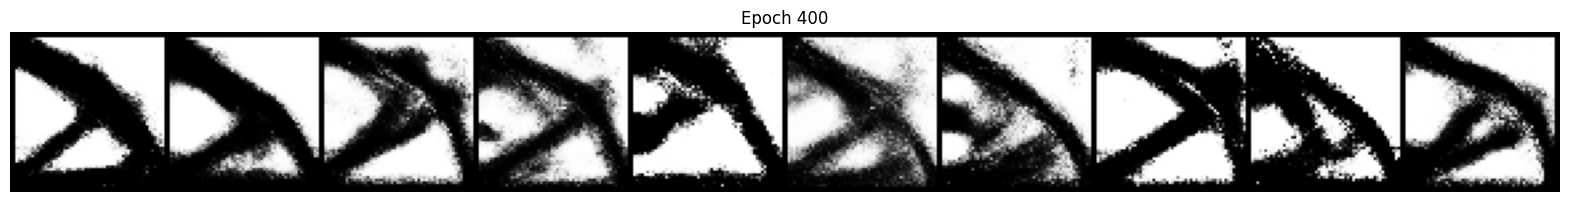

Epoch [401/500]  D Loss: 0.3656  G Loss: 2.5058
Epoch [402/500]  D Loss: 0.2914  G Loss: 2.5837
Epoch [403/500]  D Loss: 0.3156  G Loss: 2.6129
Epoch [404/500]  D Loss: 0.3422  G Loss: 2.4987
Epoch [405/500]  D Loss: 0.3141  G Loss: 2.6852
Epoch [406/500]  D Loss: 0.3168  G Loss: 2.7471
Epoch [407/500]  D Loss: 0.3306  G Loss: 2.6073
Epoch [408/500]  D Loss: 0.3136  G Loss: 2.8241
Epoch [409/500]  D Loss: 0.3571  G Loss: 2.6183
Epoch [410/500]  D Loss: 0.3117  G Loss: 2.6279
Epoch [411/500]  D Loss: 0.3190  G Loss: 2.6055
Epoch [412/500]  D Loss: 0.3386  G Loss: 2.5654
Epoch [413/500]  D Loss: 0.3264  G Loss: 2.5593
Epoch [414/500]  D Loss: 0.3141  G Loss: 2.6573
Epoch [415/500]  D Loss: 0.3280  G Loss: 2.6297
Epoch [416/500]  D Loss: 0.3607  G Loss: 2.3293
Epoch [417/500]  D Loss: 0.3219  G Loss: 2.6733
Epoch [418/500]  D Loss: 0.3248  G Loss: 2.6378
Epoch [419/500]  D Loss: 0.3481  G Loss: 2.4760
Epoch [420/500]  D Loss: 0.3269  G Loss: 2.5665
Epoch [421/500]  D Loss: 0.3268  G Loss:

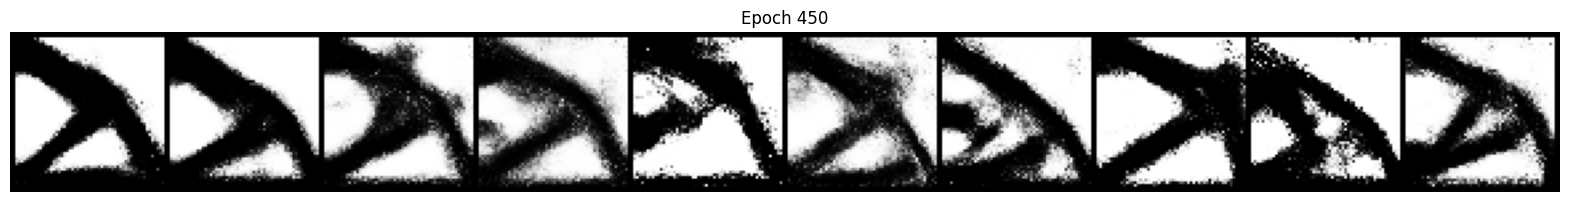

Epoch [451/500]  D Loss: 0.3228  G Loss: 2.5891
Epoch [452/500]  D Loss: 0.2906  G Loss: 2.7561
Epoch [453/500]  D Loss: 0.2922  G Loss: 2.7800
Epoch [454/500]  D Loss: 0.3172  G Loss: 2.7639
Epoch [455/500]  D Loss: 0.3401  G Loss: 2.6299
Epoch [456/500]  D Loss: 0.3124  G Loss: 2.8347
Epoch [457/500]  D Loss: 0.3289  G Loss: 2.6563
Epoch [458/500]  D Loss: 0.3113  G Loss: 2.5991
Epoch [459/500]  D Loss: 0.3209  G Loss: 2.7789
Epoch [460/500]  D Loss: 0.3038  G Loss: 2.6746
Epoch [461/500]  D Loss: 0.2991  G Loss: 2.8311
Epoch [462/500]  D Loss: 0.3264  G Loss: 2.6054
Epoch [463/500]  D Loss: 0.2726  G Loss: 3.0035
Epoch [464/500]  D Loss: 0.3310  G Loss: 2.6923
Epoch [465/500]  D Loss: 0.3303  G Loss: 2.5329
Epoch [466/500]  D Loss: 0.3085  G Loss: 2.8713
Epoch [467/500]  D Loss: 0.2909  G Loss: 3.0196
Epoch [468/500]  D Loss: 0.3211  G Loss: 2.6318
Epoch [469/500]  D Loss: 0.3111  G Loss: 2.5982
Epoch [470/500]  D Loss: 0.3065  G Loss: 2.6950
Epoch [471/500]  D Loss: 0.3254  G Loss:

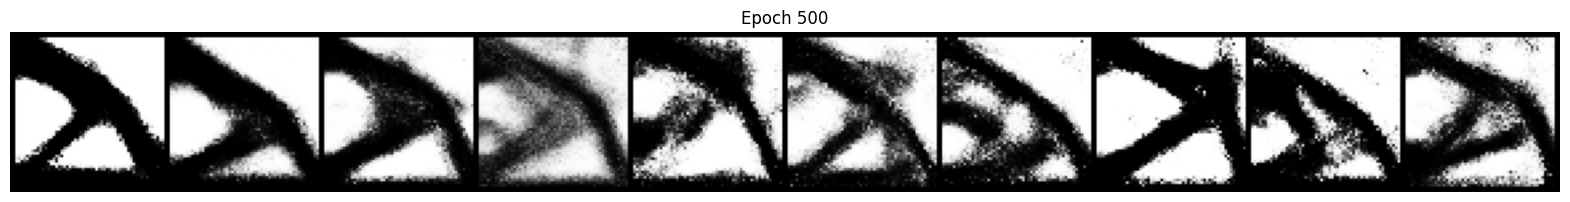

In [ ]:
"""
Training part
"""
for epoch in range(1, num_epoch + 1):

    total_g_loss = 0.0  # initialize total generator loss for the epoch
    total_d_loss = 0.0  # initialize total discriminator loss for the epoch

    for i, (imgs, labels) in enumerate(train_loader):
        batch_size_current = imgs.size(0)

        # make ground truth (labels) -> [1 / Real] & [0 / Fake]
        real = torch.ones(batch_size_current, 1).to(device)
        fake = torch.zeros(batch_size_current, 1).to(device)

        # reshape real images --> flatten to (batch_size, 56*56)
        real_imgs = imgs.view(batch_size_current, -1).to(device)  # flatten image to (batch_size, 56*56)
        labels = labels.to(device)

        # +---------------------+
        # | train Discriminator |
        # +---------------------+

        # initialize gradient -> initialize discriminator model gradient to 0
        discriminator.zero_grad()

        # discriminator loss on real images
        output_real = discriminator(real_imgs, labels)
        d_loss_real = criterion(output_real, real)

        # generate fake images and get discriminator output
        z = torch.randn(batch_size_current, noise_size).to(device)
        fake_imgs = generator(z, labels)
        output_fake = discriminator(fake_imgs.detach(), labels)
        d_loss_fake = criterion(output_fake, fake)

        # total discriminator loss
        d_loss = (d_loss_real + d_loss_fake) / 2

        # train discriminator with backpropagation
        d_loss.backward()
        d_optimizer.step()

        # accumulate d_loss
        total_d_loss += d_loss.item()

        # +---------------------+
        # |   train Generator   |
        # +---------------------+

        # initialize gradient -> initialize generator model gradient to 0
        generator.zero_grad()

        # compare result of discriminator with fake images & real labels
        # if generator deceives discriminator, g_loss will decrease
        output = discriminator(fake_imgs, labels)
        g_loss = criterion(output, real)  # generator wants discriminator to label fake as real

        # train generator with backpropagation
        g_loss.backward()
        g_optimizer.step()

        # accumulate g_loss
        total_g_loss += g_loss.item()

    # calculate average losses for the epoch
    avg_g_loss = total_g_loss / len(train_loader)
    avg_d_loss = total_d_loss / len(train_loader)

    # save the average loss for this epoch
    g_loss_history.append(avg_g_loss)
    d_loss_history.append(avg_d_loss)

    # print losses at the end of each epoch
    print(f"Epoch [{epoch}/{num_epoch}]  D Loss: {avg_d_loss:.4f}  G Loss: {avg_g_loss:.4f}")

    # save and visualize generated images at specific intervals
    if epoch % 50 == 0 or epoch == 1:
        with torch.no_grad():
            # generate a set of images with a range of Y values
            fake_images = generator(fixed_noise, fixed_labels).detach().cpu()
        fake_images = fake_images.view(-1, 1, 56, 56)

        # save images as a grid using save_image
        save_image(fake_images, f"./cGAN_samples/cGAN_epoch_{epoch}.png", nrow=10, normalize=True)

        # display the generated images
        plt.figure(figsize=(20, 4))
        img = plt.imread(f"./cGAN_samples/cGAN_epoch_{epoch}.png")
        plt.imshow(img)
        plt.title(f"Epoch {epoch}")
        plt.axis('off')
        plt.show()

        # optionally, save model checkpoints
        if epoch % 50 == 0 or epoch == num_epoch:
            torch.save(generator.state_dict(), f"./cGAN_samples/generator_epoch_{epoch}.pth")
            torch.save(discriminator.state_dict(), f"./cGAN_samples/discriminator_epoch_{epoch}.pth")

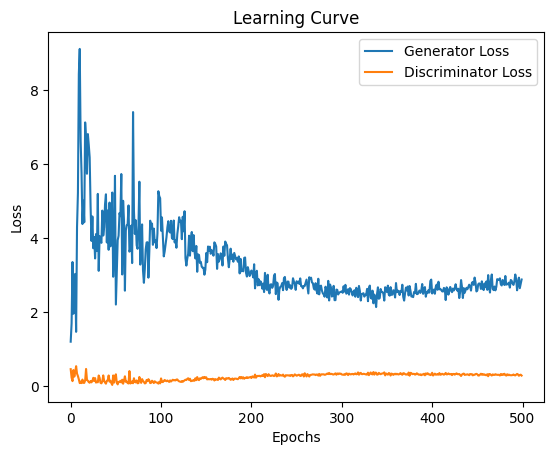

In [ ]:
# graph visualization
plot_loss(g_loss_history, d_loss_history, 'Learning Curve')  # loss variation over epochs during training
plt.show()

## 8. Load & Evaluate model

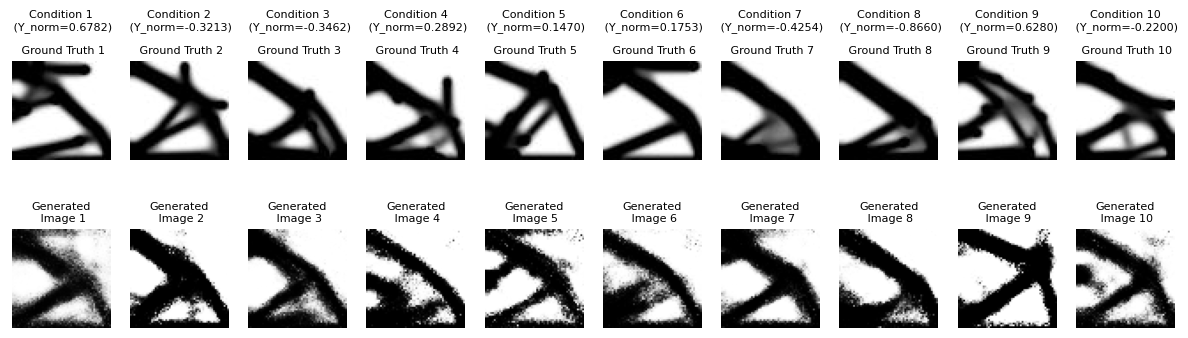

In [ ]:
# final image generation and visualization using 10 samples from the test dataset
with torch.no_grad():

    # select 10 samples from the test dataset
    num_samples = 10

    test_images_sample = torch.tensor(X_test[:num_samples], dtype=torch.float32).to(device)
    test_labels_sample = torch.tensor(y_test[:num_samples], dtype=torch.float32).unsqueeze(1).to(device)

    # generate fake images based on the test labels
    noise_sample = torch.randn(num_samples, noise_size).to(device)
    generated_images = generator(noise_sample, test_labels_sample).cpu()
    generated_images = generated_images.view(-1, 1, 56, 56)  # reshape generated images

    # create a figure to display the original and generated images
    fig, axs = plt.subplots(2, num_samples, figsize=(15, 4))

    for i in range(num_samples):
        # display the original image (conditions)
        axs[0, i].imshow(test_images_sample[i].cpu().numpy().reshape(56, 56), cmap='gray', vmin=-1, vmax=1)
        axs[0, i].set_title(f"Condition {i+1}\n (Y_norm={y_test[i]:.4f})\n\n Ground Truth {i+1}", fontsize=8)
        axs[0, i].axis('off')

        # display the generated image (generated images with each condition)
        axs[1, i].imshow(generated_images[i].detach().cpu().numpy().reshape(56, 56), cmap='gray', vmin=-1, vmax=1)
        axs[1, i].set_title(f"Generated\n Image {i+1}", fontsize=8)
        axs[1, i].axis('off')

    plt.show()